In [177]:
import os
import cv2
import OpenEXR
import Imath
import numpy as np
import pandas as pd
import open3d as o3d
from scipy.spatial.transform import Rotation as R_scipy


import matplotlib.pyplot as plt

from dataset.base_dataset import BaseDataset

In [260]:
class shapenetsem(BaseDataset):
    def __init__(self, data_path, objs_path="D:/Documentos/Depth-mass-estimation/datasets/ShapeNetSem-master/ShapeNetSem/models-OBJ-textures/models-and-textures/", filenames_path='./dataset/filenames/',
                 metadata_path='./dataset/filenames/shapenetsem/metadata.txt',
                 is_train=True, colored_pc=False, pc_dims=1024):
        super().__init__(colored_pc, pc_dims)

        self.is_train = is_train
        self.data_path = os.path.join(data_path, 'shapenetsem')
        self.objs_path = objs_path

        camera_angle = 30.0
        self.switcher = {
            '000': (np.radians(-camera_angle), 0.0, 0.0),
            '045': (np.radians(-camera_angle), 0.0, np.radians(-45.0)),
            '090': (np.radians(-camera_angle), 0.0, np.radians(-90.0)),
            '135': (np.radians(-camera_angle), 0.0, np.radians(-135.0)),
            '180': (np.radians(-camera_angle), 0.0, np.radians(-180.0)),
            '225': (np.radians(-camera_angle), 0.0, np.radians(-225.0)),
            '270': (np.radians(-camera_angle), 0.0, np.radians(-270.0)),
            '315': (np.radians(-camera_angle), 0.0, np.radians(-315.0)),
            'top': (np.radians(-camera_angle), 0.0, 0.0),
            'bottom': (np.radians(90), 0.0, 0.0),
            'left': (0.0, 0.0, np.radians(-90)),
            'right': (0.0, 0.0, np.radians(90)),
            'front': (0.0, 0.0, 0.0),
            'back': (0.0, 0.0, np.radians(180))
        }

        txt_path = os.path.join(filenames_path, 'shapenetsem')

        if is_train:
            txt_path += '/list_train.txt'
        else:
            txt_path += '/list_test.txt'

        self.filenames_list = self.readTXT(txt_path)
        self.metadata = pd.read_csv(metadata_path)
        phase = 'train' if is_train else 'test'
        print("Dataset: Shapenet Sem")
        print("# of %s images: %d" % (phase, len(self.filenames_list)))

    def __len__(self):
        if self.is_train:
            return len(self.filenames_list) // 14 * 3
        else:
            return len(self.filenames_list)

    def __getitem__(self, idx):
        if self.is_train:
            # wrap around after (len(self.filenames_list) // 14) - 1
            idx = idx % (len(self.filenames_list) // 14)
            # Each object has 14 views, randomly select one of them
            idx *= 14
            idx += np.random.randint(0, 14, 1)[0]
        
        img_path = self.data_path + self.filenames_list[idx].split(' ')[0]
        gt_path = self.data_path + self.filenames_list[idx].split(' ')[1]

        print(img_path)
        print(gt_path)

        image = self.get_image(img_path)
        depth = self.read_exr(gt_path)
        mass = self.get_mass(img_path)
        model = self.get_obj(img_path)

        filename = img_path.split('/')[-1]

        if self.is_train:
            image, pc_input, _ = self.augment_training_data(image, depth, model)
        else:
            pc_input = self.get_pointcloud(depth)
        
        pc_input = self.to_tensor(pc_input)
        image = self.convert_to_densenet_input(image)

        return {'image': image, 'pc_incomplete': pc_input, 'pc_sparse': False, 'pc_complete': False, 'mass': mass, 'filename': filename}
    
    def get_image(self, file_path):
        image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
        alpha = image[:, :, 3]
        image[alpha == 0] = (255, 255, 255, 0)
        image = image[:, :, :3]

        return image
    
    def read_exr(self, file_path):
        exr_file = OpenEXR.InputFile(file_path)
        dw = exr_file.header()['dataWindow']
        size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        redstr = exr_file.channel('R', pt)
        red = np.fromstring(redstr, dtype = np.float32)
        red.shape = (size[1], size[0]) # Numpy arrays are (row, col)

        return red
    
    def get_mass(self, img_path):
        id_str = 'wss.' + img_path.split('/')[5] #3
        index = self.metadata.loc[self.metadata['fullId'] == id_str].index[0]
        return self.metadata['weight'][index]
    
    def get_obj(self, img_path):
        obj_path = self.objs_path + img_path.split('/')[-2] + '.obj'
        mesh = o3d.io.read_triangle_mesh(obj_path)
        mesh = self.center_and_normalize(mesh)
        mesh = self.rotate_mesh(mesh, img_path)

        return mesh
    
    def center_and_normalize(self, mesh):
        bbox = mesh.get_axis_aligned_bounding_box()
        center = bbox.get_center()
        mesh.translate(-center, relative=False)
        extent = bbox.get_extent()
        mesh.scale(1 / np.max(extent), center=(0, 0, 0))

        return mesh
    
    def rotate_mesh(self, mesh, img_path):
        id_str = 'wss.' + img_path.split('/')[5] #3
        index = self.metadata.loc[self.metadata['fullId'] == id_str].index[0]
        up = self.metadata['up'][index]
        front = self.metadata['front'][index]

        if isinstance(up, str):
            up_model = np.array(list(map(float, up.split('\\,'))))
            front_model = np.array(list(map(float, front.split('\\,'))))
            up_blender = np.array([0.0, 0.0, 1.0])
            front_blender = np.array([0.0, -1.0, 0.0])

            rotation_up = self.get_rotation_matrix(up_model, up_blender)
            front_model_rotated = np.dot(rotation_up, front_model)
            rotation_front = self.get_rotation_matrix(front_model_rotated, front_blender)
            rotation = np.dot(rotation_front, rotation_up)

            mesh.rotate(rotation, center=(0, 0, 0))
        
        angle_str = img_path.split('/')[6].split('_')[-1].split('.')[0] #4
        angle = list(self.switcher[angle_str])
        rotation = R_scipy.from_euler('xyz', angle)
        rotation = rotation.as_matrix()
        mesh.rotate(rotation, center=(0, 0, 0))
        
        return mesh
    
    def get_rotation_matrix(self, a, b):
        v = np.cross(a, b)
        c = np.dot(a, b)
        s = np.linalg.norm(v)
        I = np.identity(3)

        if s == 0:
            return I

        # Skew-symmetric cross-product matrix of v
        v_x = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

        # Rotation matrix
        R = I + v_x + np.dot(v_x, v_x) * ((1 - c) / (s ** 2))

        return R

In [258]:
dataset = shapenetsem("D:/Documentos/Depth-mass-estimation/datasets/")

Dataset: Shapenet Sem
# of train images: 50624


D:/Documentos/Depth-mass-estimation/datasets/shapenetsem/da78e9e94e592bc9d272dd7b90131941/da78e9e94e592bc9d272dd7b90131941_top.png
D:/Documentos/Depth-mass-estimation/datasets/shapenetsem/da78e9e94e592bc9d272dd7b90131941/da78e9e94e592bc9d272dd7b90131941_top_depth0001.exr
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


d:\Documentos\anaconda3\envs\GLPDepth\lib\site-packages\ipykernel_launcher.py:101: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


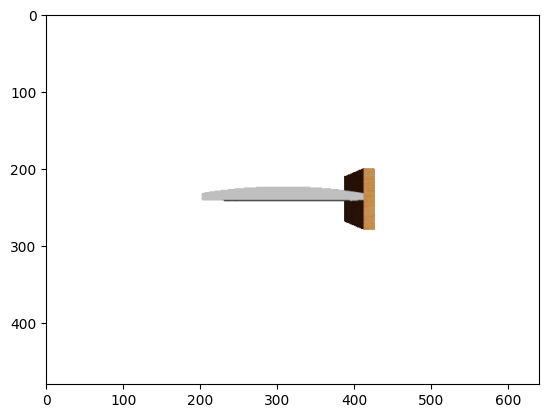

{'image': tensor([[[[1.9920, 1.9920, 1.9920,  ..., 1.9920, 1.9920, 1.9920],
           [1.9920, 1.9920, 1.9920,  ..., 1.9920, 1.9920, 1.9920],
           [1.9920, 1.9920, 1.9920,  ..., 1.9920, 1.9920, 1.9920],
           ...,
           [1.9920, 1.9920, 1.9920,  ..., 1.9920, 1.9920, 1.9920],
           [1.9920, 1.9920, 1.9920,  ..., 1.9920, 1.9920, 1.9920],
           [1.9920, 1.9920, 1.9920,  ..., 1.9920, 1.9920, 1.9920]],
 
          [[2.1660, 2.1660, 2.1660,  ..., 2.1660, 2.1660, 2.1660],
           [2.1660, 2.1660, 2.1660,  ..., 2.1660, 2.1660, 2.1660],
           [2.1660, 2.1660, 2.1660,  ..., 2.1660, 2.1660, 2.1660],
           ...,
           [2.1660, 2.1660, 2.1660,  ..., 2.1660, 2.1660, 2.1660],
           [2.1660, 2.1660, 2.1660,  ..., 2.1660, 2.1660, 2.1660],
           [2.1660, 2.1660, 2.1660,  ..., 2.1660, 2.1660, 2.1660]],
 
          [[2.3786, 2.3786, 2.3786,  ..., 2.3786, 2.3786, 2.3786],
           [2.3786, 2.3786, 2.3786,  ..., 2.3786, 2.3786, 2.3786],
           [2.3

In [261]:
dataset[1]